In [1]:
"""
f(R) gravity emulator: for fast generation of P_mg/P_lcdm


Requires the following installations:

1. gpflow
2. scipy
3. sklearn 
"""

'\nf(R) gravity emulator: for fast generation of P_mg/P_lcdm\n\n\nRequires the following installations:\n\n1. gpflow\n2. scipy\n3. sklearn \n'

# This code outputs $r(k, \theta)$, where $r(k) = P_{MG}(k) /P_{LCDM}(k)$ and $\theta = \{\Omega_m, n_s, \sigma_8, f_{R_0}, n\}$


In [2]:
import numpy as np
import matplotlib.pylab as plt
import time
import glob
import os

import pickle
from sklearn.decomposition import PCA
import gpflow

# import mgemu


from itertools import cycle
import matplotlib.ticker as ticker
from matplotlib import gridspec

In [3]:
############################# PARAMETERS ##############################

dataDir = "../data/" ## Data folder
modelDir = "../models/" ## Data folder
plotsDir = "../plots/" ## Data folder

nRankMax = 16  ## 
snap_ID = 97

GPfile = modelDir + 'GPflow_model_213Smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)
lhdmin, lhdmax = np.loadtxt(dataDir + 'paralims.txt')
PCAfile = modelDir + 'PCA_model' + str(nRankMax)

################################# I/O #################################


In [4]:
######################## GP PREDICTION FUNCTIONS ###############################

def rescale01(f):
    return np.min(f), np.max(f), (f - np.min(f)) / (np.max(f) - np.min(f))

def scale01(fmin, fmax, f):
    return (f - fmin) / (fmax - fmin)


# emulator(GPmoduleFile, PCAmoduleFile)

def load_models(GPmodelFile, PCAmodelFile):
    ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
    saver = gpflow.saver.Saver()
    gpmodel = saver.load(GPmodelFile, context=ctx_for_loading)
    gpmodel.clear()
    gpmodel.compile()
    
    pcamodel = pickle.load(open(PCAmodelFile, 'rb'))
    return gpmodel, pcamodel  
    
def gp_predict(para_array):  
    gpm = gpmodel.predict_f(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = gpm[0]
    W_varArray = gpm[1]
    return W_predArray, W_varArray

def emu(para_array):
    
    kvals = np.loadtxt('../data/kvals.txt')
    if ((para_array < lhdmin).any() or (para_array > lhdmax).any() ):
        print('Warning: input cosmology parameters outside range of the emulator, extrapolation may not be accurate')   
    if len(para_array.shape) == 1:
        para_array_rescaled = scale01(lhdmin, lhdmax, para_array)
        W_predArray, _ = gp_predict(np.expand_dims(para_array_rescaled, axis=0))
        x_decoded = pcamodel.inverse_transform(W_predArray)
        return kvals, np.squeeze(x_decoded)#[0]

## Sample calling the emulator for a given cosmology $\{\Omega_m, n_s, \sigma_8, f_{R_0}, n\}$

In [5]:
gpmodel, pcamodel = load_models(GPfile, PCAfile)

pcosmos = np.array([0.14, 0.88, 0.8, 1e-6, 2]) # Test cosmology parameters
ks, rCosmo = emu(pcosmos) # power spectra ratio

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


/anaconda3/envs/tf_gpu/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator PCA from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


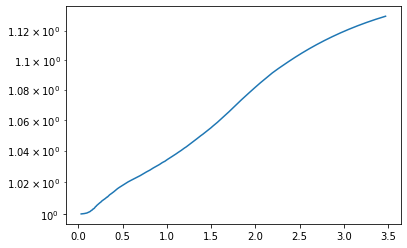

In [6]:
plt.plot(ks, rCosmo)
plt.yscale('log')

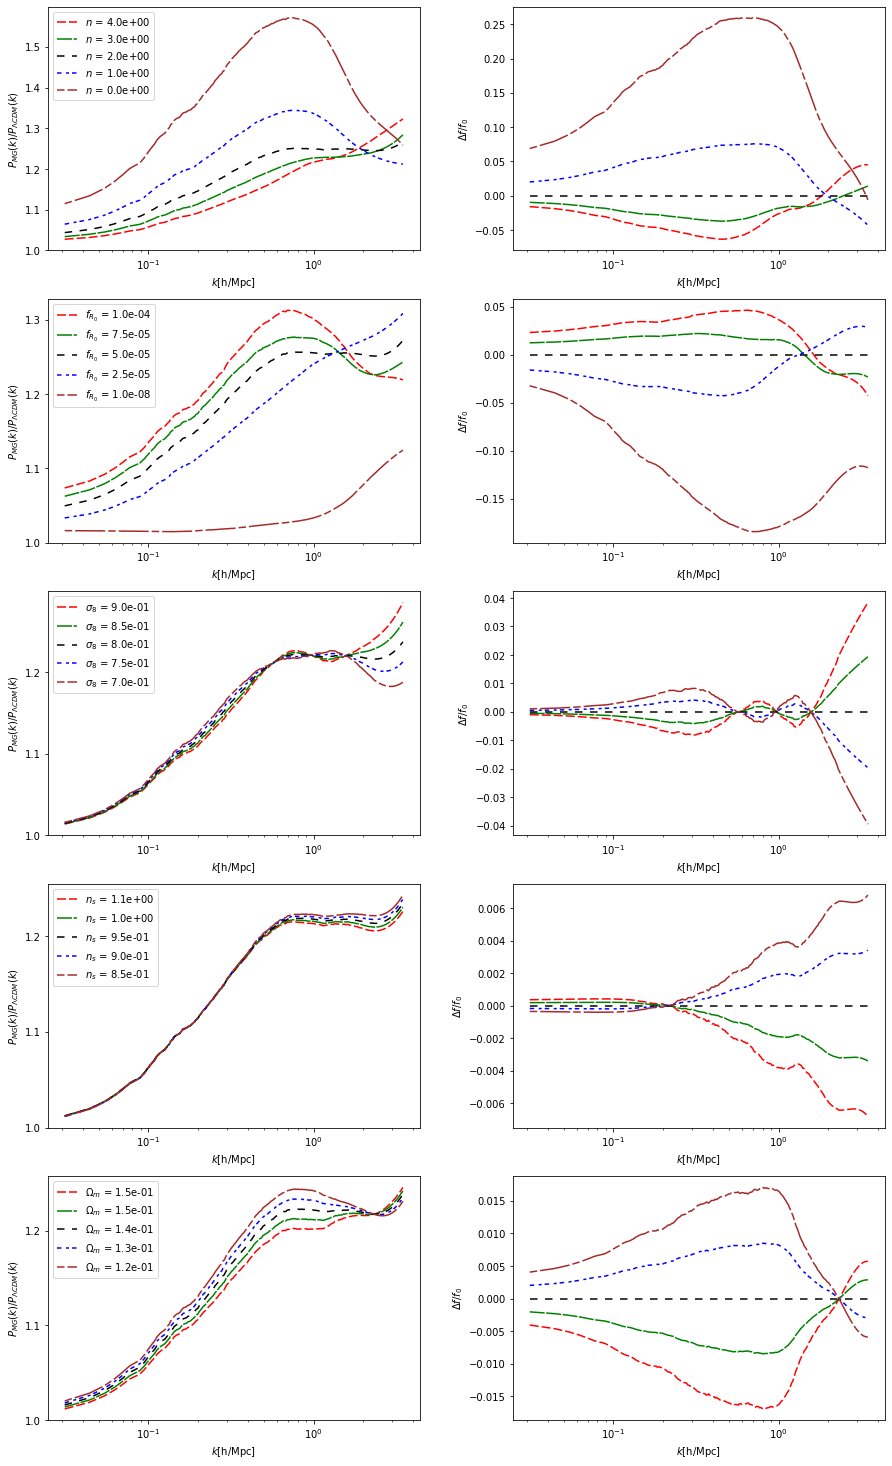

In [11]:
kvals = np.loadtxt(dataDir+'kvals.txt')
allLabels = [r'${\Omega}_m$', r'$n_s$', r'${\sigma}_8$', r'$f_{R_0}$', r'$n$']


PlotCls = True

if PlotCls:
    
    numPlots = 5

    fig, ax = plt.subplots(5,2, figsize = (15,26))
    plt.subplots_adjust(wspace=0.25)
    
    allMax = lhdmin
    allMin = lhdmax
    allMean = (lhdmax + lhdmin)/2.0
    kvals, Pk_mean = emu(allMean) 
    
    for paramNo in range(5):
        para_range = np.linspace(allMin[paramNo], allMax[paramNo], numPlots)

        lines = ["-","-.","--",":"]
        linecycler = cycle(lines)
        dashList = [(6,2),(10,1),(5,5),(3,3,2,2),(5,2,20,2)]
        colorList = ['r', 'g', 'k', 'b', 'brown']


        for plotID in range(numPlots):
            para_plot = np.copy(allMean)
            para_plot[paramNo] = para_range[plotID]  
            _, x_decodedGPy = emu(para_plot) 
            lineObj = ax[4-paramNo,0].plot(kvals, x_decodedGPy, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = allLabels[paramNo] + ' = %.1e'%para_range[plotID])

            ax[4-paramNo,0].set_xscale('log')
            ax[4-paramNo,0].set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
            ax[4-paramNo,0].set_xlabel('$k$[h/Mpc]')
            
            ax[4-paramNo,0].set_yticks([], minor = True)
            ax[4-paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
            ax[4-paramNo,0].legend()

            ax[4-paramNo,1].set_xscale('log')
            ax[4-paramNo,1].set_ylabel(r'$\Delta f / f_0$')
            ax[4-paramNo,1].set_xlabel('$k$[h/Mpc]')

            ax[4-paramNo,1].plot(kvals, (x_decodedGPy)/(Pk_mean) - 1, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = para_range[plotID] )


        start, end = ax[4-paramNo, 0].get_ylim()
        ax[4-paramNo, 0].yaxis.set_ticks( (np.arange(start, end, 0.1)))
        ax[4-paramNo, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


fig.savefig(plotsDir + "sensitivity.png",  bbox_inches="tight", dpi=200)

plt.show()